In [3]:
import torch
import torch.nn as nn
import time
from ode_nn import Seq2Seq, Auto_FC, Transformer, Latent_ODE
from ode_nn import Dataset, train_epoch, eval_epoch, get_lr
import numpy as np
import time
from torch.utils import data
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

## Data Loaders

In [4]:
# for idx in range(2800, 4000, 100):
input_length = 20
mid = 20
output_length = 40
batch_size = 256
####################################
direc = '/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/SEIR_Data/sample_'
random.seed(1521)
indices = list(range(1000, 5000))
random.shuffle(indices)

train_indices = indices[:3000]
valid_indices = indices[3000:3500]
test_inter_indices = indices[3500:4000]

test_extra_up_indices = list(range(4000, 5000, 2))
test_extra_down_indices = list(range(0, 1000, 2))
####################################
train_set = Dataset(train_indices, input_length, mid, output_length, direc, entire_target = False)
valid_set = Dataset(valid_indices, input_length, mid, output_length, direc, entire_target = False)
test_inter_set = Dataset(test_inter_indices, input_length, mid, output_length, direc, entire_target = False)
test_down_set = Dataset(test_extra_down_indices, input_length, mid, output_length, direc, entire_target = False)
test_up_set = Dataset(test_extra_up_indices, input_length, mid, output_length, direc, entire_target = False)

train_loader = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
test_inter_loader = data.DataLoader(test_inter_set, batch_size = batch_size, shuffle = False)
test_down_loader = data.DataLoader(test_down_set, batch_size = batch_size, shuffle = False)
test_up_loader = data.DataLoader(test_up_set, batch_size = batch_size, shuffle = False)
#model = nn.DataParallel(Auto_FC(input_length = 20, input_dim = 3, output_dim = 3, hidden_dim = 64).to(device))
model = Seq2Seq(input_dim = 3, output_dim = 3, hidden_dim = 64, num_layers = 1).to(device)#)nn.DataParallel(
#model = nn.DataParallel(Transformer(input_dim = 3, output_dim = 3, nhead = 4, d_model = 32, num_layers = 3, dim_feedforward = 64).to(device))
#model = nn.DataParallel(Latent_ODE(latent_dim = 32, obs_dim=3, nhidden = 64, nbatch=batch_size).to(device))
####################################
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = nn.MSELoss()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
train_rmse = []
valid_rmse = []
test_rmse = []
min_rmse = 1
for i in range(1, 80):
    start = time.time()
    scheduler.step()
    model.train()
    train_rmse.append(train_epoch(model, train_loader, optimizer, loss_fun)[-1])
    model.eval()
    preds, trues, rmse = eval_epoch(model, valid_loader, loss_fun, concat_input = False)
    valid_rmse.append(rmse)
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model 
       # torch.save(best_model, "seq2seq2.pth")
    end = time.time()
    if (len(train_rmse) > 30 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
    if i%10 == 0:
        print("Epoch " + str(i) + ": ", "train rmse:", train_rmse[-1], "valid rmse:",valid_rmse[-1], 
                      "time:",round((end-start)/60,3), "Learning rate:", format(get_lr(optimizer), "5.2e"))

preds_inter, trues_inter, rmse_inter = eval_epoch(best_model, test_inter_loader, loss_fun, concat_input = True)
preds_down, trues_down, rmse_down = eval_epoch(best_model, test_down_loader, loss_fun, concat_input = True)
preds_up, trues_up, rmse_up = eval_epoch(best_model, test_up_loader, loss_fun, concat_input = True)

torch.save({"Inter": [preds_inter, trues_inter, rmse_inter],
            "Down": [preds_down, trues_down, rmse_down],
            "Up": [preds_up, trues_up, rmse_up],
            "model": best_model},
            "seq2seq"+ str(idx) + ".pt")

# preds_inter, trues_inter, rmse_inter = eval_epoch(best_model, test_inter_loader, loss_fun, concat_input = True)
# preds_down, trues_down, rmse_down = eval_epoch(best_model, test_down_loader, loss_fun, concat_input = True)
# preds_up, trues_up, rmse_up = eval_epoch(best_model, test_up_loader, loss_fun, concat_input = True)

# torch.save({"Inter": [preds_inter, trues_inter, rmse_inter],
#         "Down": [preds_down, trues_down, rmse_down],
#         "Up": [preds_up, trues_up, rmse_up],
#         "model": best_model},
#         "seq2seq"+ str(idx) + ".pt")

## Train Model

In [3]:
# best_model = torch.load("latentode.pth")
# preds_inter, trues_inter, rmse_inter = eval_epoch(best_model, test_inter_loader, loss_fun, concat_input = False)
# preds_down, trues_down, rmse_down = eval_epoch(best_model, test_down_loader, loss_fun, concat_input = False)
# preds_up, trues_up, rmse_up = eval_epoch(best_model, test_up_loader, loss_fun, concat_input = False)

# torch.save({"Inter": [preds_inter, trues_inter, rmse_inter],
#             "Down": [preds_down, trues_down, rmse_down],
#             "Up": [preds_up, trues_up, rmse_up],
#             "model": best_model},
#             "latentode.pt")

In [ ]:
#model = nn.DataParallel(Auto_FC(input_length = 20, input_dim = 3, output_dim = 3, hidden_dim = 64).to(device))
#model = nn.DataParallel(Seq2Seq(input_dim = 3, output_dim = 3, hidden_dim = 64, num_layers = 1).to(device))
model = nn.DataParallel(Transformer(input_dim = 3, output_dim = 3, nhead = 4, d_model = 32, num_layers = 3, dim_feedforward = 64).to(device))
#model = nn.DataParallel(Latent_ODE(latent_dim = 32, obs_dim=3, nhidden = 64, nbatch=batch_size).to(device))
####################################
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
loss_fun = nn.MSELoss()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
train_rmse = []
valid_rmse = []
test_rmse = []
min_rmse = 1
for i in range(1, 40):
    start = time.time()
    scheduler.step()
    model.train()
    train_rmse.append(train_epoch(model, train_loader, optimizer, loss_fun)[-1])
    model.eval()
    preds, trues, rmse = eval_epoch(model, valid_loader, loss_fun, concat_input = False)
    valid_rmse.append(rmse)
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model 
       # torch.save(best_model, "seq2seq2.pth")
    end = time.time()
    if (len(train_rmse) > 30 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
    if i%10 == 0:
        print("Epoch " + str(i) + ": ", "train rmse:", train_rmse[-1], "valid rmse:",valid_rmse[-1], 
                      "time:",round((end-start)/60,3), "Learning rate:", format(get_lr(optimizer), "5.2e"))

preds_inter, trues_inter, rmse_inter = eval_epoch(best_model, test_inter_loader, loss_fun, concat_input = True)
preds_down, trues_down, rmse_down = eval_epoch(best_model, test_down_loader, loss_fun, concat_input = True)
preds_up, trues_up, rmse_up = eval_epoch(best_model, test_up_loader, loss_fun, concat_input = True)

torch.save({"Inter": [preds_inter, trues_inter, rmse_inter],
            "Down": [preds_down, trues_down, rmse_down],
            "Up": [preds_up, trues_up, rmse_up],
            "model": best_model},
            "seq2seq2.pt")

35523


## Plots

In [85]:
results = torch.load("latentode.pt")
preds_inter, trues_inter, rmse_inter = results["Inter"]
preds_down, trues_down, rmse_down = results["Down"] 
#preds_up, trues_up, rmse_up = results["Up"]

In [89]:
preds_down.shape

(1500, 60, 4)

In [86]:
def RMSE(a, b):
    return np.sqrt(np.mean((a - b)**2)) 
print("Inter", RMSE(preds_inter[:,-40:], trues_inter[:,-40:]))
#print("Up_Extra", RMSE(preds_up[:,-40:], trues_up[:,-40:]))
print("Down_Extra", RMSE(preds_down[:,-40:], trues_down[:,-40:]))

Inter 0.004257601
Down_Extra 0.007548499


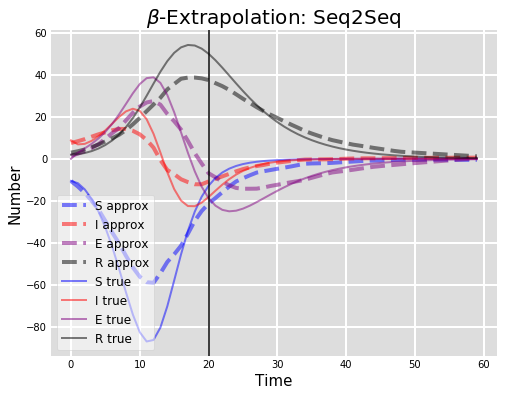

In [93]:
x = np.linspace(0, 60, 61)[:-1]
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True) #80 6 130
idx = 80
num = 0
preds = [preds_inter, preds_down]# preds_up,
trues = [trues_inter, trues_down]#trues_up, 
ax.plot(x, preds[num][idx, :, 0]*1000, 'b', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(x, preds[num][idx, :, 1]*1000, 'red', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(x, preds[num][idx, :, 2]*1000, 'purple', alpha=0.5, lw=4, linestyle = "--", label= 'E approx')
ax.plot(x, preds[num][idx, :, 3]*1000, 'black', alpha=0.5, lw=4, linestyle = "--", label= 'R approx')

ax.plot(x, trues[num][idx, :, 0]*1000, 'b', alpha=0.5, lw=2,  label='S true')
ax.plot(x, trues[num][idx, :, 1]*1000, 'red', alpha=0.5, lw=2,  label='I true')
ax.plot(x, trues[num][idx, :, 2]*1000, 'purple', alpha=0.5, lw=2,  label='E true')
ax.plot(x, trues[num][idx, :, 3]*1000, 'black', alpha=0.5, lw=2,  label='R true')


ax.axvline(20, color = "black")
ax.set_xlabel('Time', size = 15)
ax.set_ylabel('Number', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 12, loc = 3)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    plt.title(r'$\beta$-'+"Extrapolation: Seq2Seq" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("Extrapolation.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

In [34]:
errors_ups = []
errors_downs = []
models_name = ["seq2seq", "autofc", "transformer", "latentode"]
for direc in models_name:
    results = torch.load(direc + ".pt")
    preds_inter, trues_inter, rmse_inter = results["Inter"]
    preds_down, trues_down, rmse_down = results["Down"] 
    preds_up, trues_up, rmse_up = results["Up"]
    error_up = [np.sqrt(np.mean((preds_up[i,-40:] - trues_up[i,-40:])**2)) for i in range(500)]
    error_down = [np.sqrt(np.mean((preds_down[i,-40:] - trues_down[i,-40:])**2)) for i in range(500)]
    errors_ups.append(error_up)
    errors_downs.append(error_down)

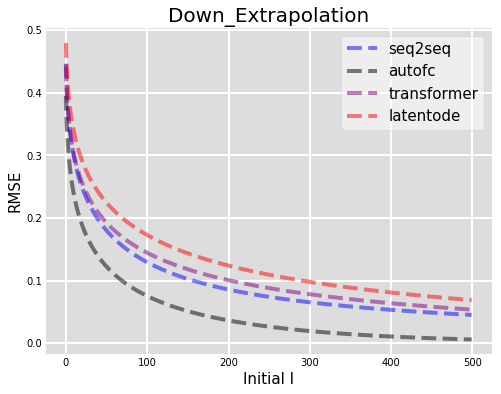

In [38]:
x_up = list(range(4500, 5000))
x_down = list(range(500))
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x_down, errors_downs[0], 'b', alpha=0.5, lw=4, linestyle = "--", label=models_name[0])
ax.plot(x_down, errors_downs[1], 'black', alpha=0.5, lw=4, linestyle = "--", label=models_name[1])
ax.plot(x_down, errors_downs[2], 'purple', alpha=0.5, lw=4, linestyle = "--", label=models_name[2])
ax.plot(x_down, errors_downs[3], 'red', alpha=0.5, lw=4, linestyle = "--", label=models_name[3])

# ax.plot(x_up, errors_ups[0], 'b', alpha=0.5, lw=4, linestyle = "--", label=models_name[0])
# ax.plot(x_up, errors_ups[1], 'black', alpha=0.5, lw=4, linestyle = "--", label=models_name[1])
# ax.plot(x_up, errors_ups[2], 'purple', alpha=0.5, lw=4, linestyle = "--", label=models_name[2])
# ax.plot(x_up, errors_ups[3], 'red', alpha=0.5, lw=4, linestyle = "--", label=models_name[3])

ax.set_xlabel('Initial I', size = 15)
ax.set_ylabel('RMSE', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 15, loc = 0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Down_Extrapolation" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("Down_Extrapolation.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

In [6]:
error_up = []
error_down = []
error_inter = []
num_samples = list(range(3200, 500, -100))
for idx in num_samples:
    results = torch.load("Generalization/seq2seq"+ str(idx) + ".pt")
    preds_inter, trues_inter, rmse_inter = results["Inter"]
    preds_down, trues_down, rmse_down = results["Down"] 
    preds_up, trues_up, rmse_up = results["Up"]
    error_up.append(np.sqrt(np.mean((preds_up[:,-40:] - trues_up[:,-40:])**2))) 
    error_down.append(np.sqrt(np.mean((preds_down[:,-40:] - trues_down[:,-40:])**2))) 
    error_inter.append(np.sqrt(np.mean((preds_inter[:,-40:] - trues_inter[:,-40:])**2))) 

No handles with labels found to put in legend.


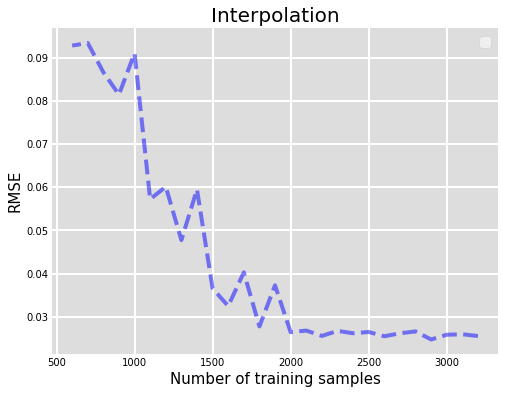

In [10]:
fig=plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(num_samples, error_inter, 'b', alpha=0.5, lw=4, linestyle = "--")#, label=models_name[0]
# ax.plot(x_down, errors_downs[1], 'black', alpha=0.5, lw=4, linestyle = "--", label=models_name[1])
# ax.plot(x_down, errors_downs[2], 'purple', alpha=0.5, lw=4, linestyle = "--", label=models_name[2])
# ax.plot(x_down, errors_downs[3], 'red', alpha=0.5, lw=4, linestyle = "--", label=models_name[3])

# ax.plot(x_up, errors_ups[0], 'b', alpha=0.5, lw=4, linestyle = "--", label=models_name[0])
# ax.plot(x_up, errors_ups[1], 'black', alpha=0.5, lw=4, linestyle = "--", label=models_name[1])
# ax.plot(x_up, errors_ups[2], 'purple', alpha=0.5, lw=4, linestyle = "--", label=models_name[2])
# ax.plot(x_up, errors_ups[3], 'red', alpha=0.5, lw=4, linestyle = "--", label=models_name[3])

ax.set_xlabel('Number of training samples', size = 15)
ax.set_ylabel('RMSE', size = 15)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize = 15, loc = 0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title("Interpolation" , fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"
#plt.savefig("Interpolation-numofsamples.png", dpi = 400 , bbox_inches = "tight")    
plt.show()

## Learn $\beta, \gamma, y_0$ + ODE solver

In [ ]:
model = Neural_ODE(input_dim = 4, input_length = 20, hidden_dim = 128, solver = "RK4", encoder = "fc").cuda()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.98)
loss_fun = nn.MSELoss()
train_rmse = []
valid_rmse = []
test_rmse = []
min_rmse = 0.01461

for i in range(1, 100):
    start = time.time()
    scheduler.step()
    model.train()
    train_rmse.append(train_epoch(model, train_loader, optimizer, loss_fun)[-1])
    model.eval()
    preds, trues, rmse = eval_epoch(model, valid_loader, loss_fun)
    valid_rmse.append(rmse)
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model 
        #torch.save(best_model, "fc_interpolation.pth")
    end = time.time()
    if (len(train_rmse) > 30 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
    #if i%5 == 0:
    print("Epoch " + str(i) + ": ", "train rmse:", train_rmse[-1], "valid rmse:",valid_rmse[-1], 
              "time:",round((end-start)/60,3), "Learning rate:",format(get_lr(optimizer), "5.2e"))
preds, trues, rmse = eval_epoch(best_model, test_loader, loss_fun)
torch.save({"preds": preds,
            "trues": trues,
            "rmse": np.sqrt(np.mean((trues - preds)[: -40:]**2))}, 
            "nn_seir_rk4_inter.pt")

In [47]:
import pandas as pd
us_data_confirmed = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_confirmed_US.csv")
us_data_confirmed = us_data_confirmed.groupby('Province_State').sum().drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_'], axis = 1)
us_data_confirmed = us_data_confirmed.diff(axis = 1).iloc[:,1:]
us_data_death = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_deaths_US.csv")
us_data_death = us_data_death.groupby('Province_State').sum().drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_', 'Population'], axis = 1)
us_data_death = us_data_death.diff(axis = 1).iloc[:,1:]
us_data = pd.concat([us_data_confirmed.sort_values(by = "6/14/20", ascending = False), us_data_death], axis=1, join='inner')
index = list(us_data.index)
us_data = us_data.values.reshape(58, 2, -1).transpose(0,2,1)
us_data = us_data[:50, 42:] 
us_data[us_data < 0] = 0

# standardization
std = np.std(us_data, axis = (1), keepdims = True)
avgs = np.mean(us_data, axis = (1), keepdims = True)
# std = np.repeat(std, 14, axis = 0)
# avgs = np.repeat(avgs, 14, axis = 0)

us_data_confirmed1 = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_confirmed_US.csv")
us_data_confirmed1 = us_data_confirmed1.groupby('Province_State').sum().drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_'], axis = 1)
#us_data_confirmed = us_data_confirmed.diff(axis = 1).iloc[:,1:]
us_data_death1 = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_deaths_US.csv")
us_data_death1 = us_data_death1.groupby('Province_State').sum().drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_', 'Population'], axis = 1)
#us_data_death = us_data_death.diff(axis = 1).iloc[:,1:]
us_data1 = pd.concat([us_data_confirmed1.sort_values(by = "6/14/20", ascending = False), us_data_death1], axis=1, join='inner')
us_data1 = us_data1.loc[index].copy()
us_data1 = us_data1.values.reshape(58, 2, -1).transpose(0,2,1)
us_data1 = us_data1[:50, 42:] 
us_data1[us_data1 < 0] = 0

In [34]:
np.where(index == 'Michigan')

(array([], dtype=int64),)

In [43]:
us_data1.index[24]

'Michigan'

In [25]:
# confirmed = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_confirmed_global.csv")
# recovered = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_recovered_global.csv")
# deaths = pd.read_csv("/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Raw_Covid19_Data/time_series_covid19_deaths_global.csv")
# confirmed = confirmed.copy().drop(['Province/State', "Lat", "Long"],axis =1).diff(axis = 1).iloc[:,1:]
# recovered = recovered.copy().drop(['Province/State', "Lat", "Long"],axis =1).diff(axis = 1).iloc[:,1:]
# deaths = deaths.copy().drop(['Province/State', "Lat", "Long"],axis =1).diff(axis = 1).iloc[:,1:]

# global_data = pd.concat([confirmed.sort_values(by = "6/26/20", ascending = False).iloc[:,47:], 
#                          recovered.iloc[:,47:], deaths.iloc[:,47:]], axis=1, 
#                         join='inner').values[:100].reshape(100, 3, 110).transpose(0,2,1)
# global_data[global_data < 0] = 0

# # standardization
# std = np.std(global_data, axis = (1), keepdims = True)
# avgs = np.mean(global_data, axis = (1), keepdims = True)
# std = np.repeat(std, 10, axis = 0)
# avgs = np.repeat(avgs, 10, axis = 0)

In [53]:
i = 1
preds = np.concatenate([us_data1[:,-11:-10], torch.load("Results/0626_us/fc_us_"+str(i)+".pt")["preds"][-50:,:]*std + avgs], axis = 1)
trues = np.concatenate([us_data1[:,-11:-10], torch.load("Results/0626_us/fc_us_"+str(i)+".pt")["trues"][-50:,20:]*std + avgs], axis = 1)
np.sqrt(np.mean((np.cumsum(preds, axis = 1) - np.cumsum(trues, axis = 1))**2))
#np.sqrt(np.mean((preds - trues)**2, axis = (0,2)))

1898.092066885338

In [11]:
fc_error = []
for i in range(3):
    fc_error.append(np.sqrt(np.mean((torch.load("Results/0626_global/fc_global_"+str(i)+".pt")["preds"]*std - 
                                     torch.load("Results/0626_global/fc_global_"+str(i)+".pt")["trues"][:,20:]*std)**2, axis = (0,2))))
fc_error = np.array(fc_error)

latent_error = []
for i in range(3):
    latent_error.append(np.sqrt(np.mean((torch.load("Results/0626_global/latentode_global_"+str(i)+".pt")["preds"][:,20:]*std - 
                                         torch.load("Results/0626_global/latentode_global_"+str(i)+".pt")["trues"][:,20:]*std)**2, axis = (0,2))))
latent_error = np.array(latent_error)

lstm_error = []
for i in range(3):
    lstm_error.append(np.sqrt(np.mean((torch.load("Results/0626_global/lstm_global_"+str(i)+".pt")["preds"]*std - 
                                       torch.load("Results/0626_global/lstm_global_"+str(i)+".pt")["trues"][:,20:]*std)**2, axis = (0,2))))
lstm_error = np.array(lstm_error)

transformer_error = []
for i in range(3):
    transformer_error.append(np.sqrt(np.mean((torch.load("Results/0626_global/transformer_global_"+str(i)+".pt")["preds"]*std - 
                                              torch.load("Results/0626_global/transformer_global_"+str(i)+".pt")["trues"][:,20:]*std)**2, axis = (0,2))))
transformer_error = np.array(transformer_error)

In [12]:
np.std(fc_error, axis = 0)

array([0.51909478, 0.92462634, 0.54478505, 0.80227618, 0.2338291 ,
       0.54078923, 0.51563966, 1.04871615, 0.96782937, 1.13959393])

In [13]:
np.std(latent_error, axis = 0)

array([12.87798517, 15.83469888, 15.91402846, 16.32326445, 19.11201719,
       20.50498389, 21.35598111, 21.66133668, 23.15973163, 23.70339843])

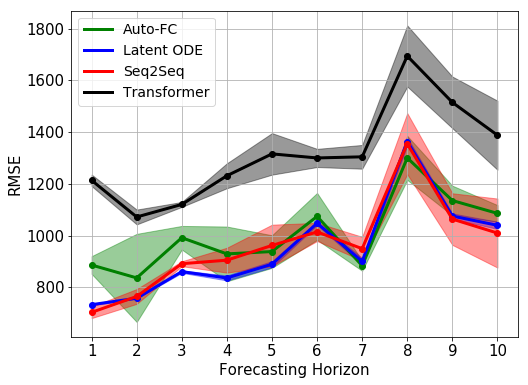

In [12]:
xidx = list(range(1,11))
fig=plt.figure(figsize=(8, 6))

plt.plot(xidx, np.mean(fc_error, axis = 0), '-', color='green', linewidth = 3, label = "Auto-FC")
plt.plot(xidx, np.mean(fc_error, axis = 0), color='green', marker = "o", markersize = 6)
plt.fill_between(xidx, np.mean(fc_error, axis = 0) - 2*np.std(fc_error, axis = 0), 
                 np.mean(fc_error, axis = 0) + 2*np.std(fc_error, axis = 0),color='green', alpha=0.4)

plt.plot(xidx, np.mean(latent_error, axis = 0), '-', color='blue', linewidth = 3, label = "Latent ODE")
plt.plot(xidx, np.mean(latent_error, axis = 0), color='blue', marker = "o", markersize = 6)
plt.fill_between(xidx, np.mean(latent_error, axis = 0) - np.std(latent_error, axis = 0), 
                 np.mean(latent_error, axis = 0) + np.std(latent_error, axis = 0),color='blue', alpha=0.4)

plt.plot(xidx, np.mean(lstm_error, axis = 0), '-', color='red', linewidth = 3, label = "Seq2Seq")
plt.plot(xidx, np.mean(lstm_error, axis = 0), color='red', marker = "o", markersize = 6)
plt.fill_between(xidx, np.mean(lstm_error, axis = 0) - 2*np.std(lstm_error, axis = 0), 
                 np.mean(lstm_error, axis = 0) + 2*np.std(lstm_error, axis = 0),color='red', alpha=0.4)

plt.plot(xidx, np.mean(transformer_error, axis = 0), '-', color='black', linewidth = 3, label = "Transformer")
plt.plot(xidx, np.mean(transformer_error, axis = 0), color='black', marker = "o", markersize = 6)
plt.fill_between(xidx, np.mean(transformer_error, axis = 0) - 2*np.std(lstm_error, axis = 0), 
                 np.mean(transformer_error, axis = 0) + 2*np.std(lstm_error, axis = 0),color='black', alpha=0.4)

#plt.xscale("log")
plt.grid(True)
#plt.xlim(1.01, 0.19)
#plt.xscale("log")
plt.xticks( xidx, ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'), fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel("RMSE("+ r'$10^3$'+")", size = 15)
plt.ylabel("RMSE", size = 15)
plt.xlabel("Forecasting Horizon", size = 15)
#plt.title("RMSE: 50 US states")
plt.legend(loc = 2, fontsize =14)
#plt.savefig("RMSE_horizon_global.png", dpi = 400, bbox_inches = 'tight')

In [ ]:
# random.seed(1521)
# list_indices = list(range(6000))
# random.shuffle(list_indices)
# train_indices = list_indices[:4000]
# valid_indices = list_indices[4000:5000]
# test_indices = list_indices[5000:6000]
# train_indices = list_indices[-4000:]
# valid_indices = list_indices[-5000:-4000]
# test_indices = list_indices[-6000:-5000]

# train_indices = list(range(4000))
# valid_indices = list(range(4000, 4800))
# test_indices = list(range(4800, 5600))
# direc = '/home/ec2-user/SageMaker/efs/Danielle/Ray/Data/Latest_Global_Covid_Data/sample_'
# list_indices = list(range(8000))
# train_indices = list_indices[:6000]
# valid_indices = list_indices[6000:7000]
# test_indices = list_indices[7000:8000]